In [29]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [5]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

### LOAD DATA

In [6]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

In [7]:
ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

In [8]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [9]:
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

### LOAD NETWORK WEIGHTS

In [10]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [11]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
fn = 'Feb04_0524_D16B1G100_DTrue'

#fn = os.path.join(fdir,fn)
fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

### CHECK NETWORKS

In [12]:
sfari_td_batch = SFARI_data[sfari_subs_td,:,:,:][0:15,:,:,:]
sfari_dupl_batch = SFARI_data[sfari_subs_dupl,:,:,:][0:15,:,:,:]
sfari_del_batch = SFARI_data[sfari_subs_del,:,:,:][0:15,:,:,:]

asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

In [13]:
def cvae_predict(im_in,idx=1):
    # 0 for ASD, 1 for TD
    #im_in = [DX_batch,TD_batch][idx]
    _zeros = np.zeros(s_encoder(im_in)[2].shape)

    v = 2
    cvae_sal_vec = np.hstack((_zeros,s_encoder(im_in)[v]))
    cvae_bg_vec = np.hstack((z_encoder(im_in)[v],_zeros))

    if idx==1:
        cvae_full_vec = np.hstack((z_encoder(im_in)[v],s_encoder(im_in)[v]))
    elif idx==0:
        cvae_full_vec = cvae_bg_vec
        
    out = cvae_decoder.predict(cvae_full_vec)
    
    return out[:,:,:,:,0]

Text(0, 0.5, 'MSE')

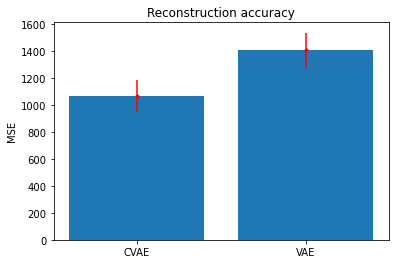

In [14]:
asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)

matIn = DX_batch
n = matIn.shape[0]

vae_out = decoder.predict(encoder(matIn)[2])[:,:,:,:,0]
cvae_out = cvae_predict(matIn,idx=1)

vae_resid = (matIn-vae_out)**2
cvae_resid = (matIn-cvae_out)**2

vae_acc = np.array([vae_resid[i,:,:,:].sum() for i in range(n)])
cvae_acc = np.array([cvae_resid[i,:,:,:].sum() for i in range(n)])

xs = [0,1];
m = [cvae_acc.mean(),vae_acc.mean()];
se = [cvae_acc.std(),vae_acc.std()];
plt.bar(xs,m);
plt.errorbar(xs,m,se,fmt='r.');
plt.xticks(xs,labels=['CVAE','VAE']);
plt.title('Reconstruction accuracy')
plt.ylabel('MSE')

### ^VAE is a bit worse at reconstruction overall. This needs to be fixed. For these analyses here it doesnt matter much because the reconstructions are still fairly ok. And also - we're mostly interested in the difference between BG and SL space

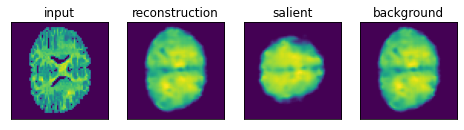

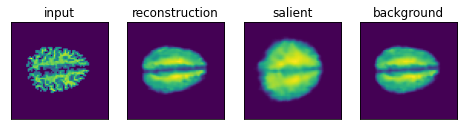

In [15]:
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0) # PLOT ASD SUBJECT
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1) # PLOT TD SUBJECT

### CVAE Reconstructions look good

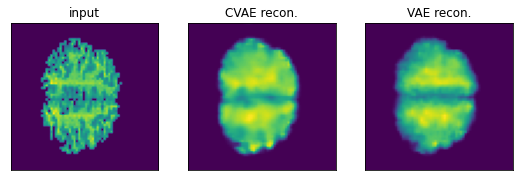

In [16]:
s = 1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1);plt.imshow(matIn[s,:,:,40]);plt.title('input');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,2);plt.imshow(cvae_out[s,:,:,40]);plt.title('CVAE recon.');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,3);plt.imshow(vae_out[s,:,:,40]);plt.title('VAE recon.');plt.xticks([]);plt.yticks([]);

### For CVAE and VAE reconstruct the brain images well

In [17]:
vae_space = dim_reduce(encoder.predict(ABIDE_data)[2])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=2, method='UMAP')

### Distributions of ASD subjects in the three spaces. Evidence of clustering in BG, SL and VAE seem random (RSA results will show how they are organized)

In [18]:
svec = s_encoder.predict(ABIDE_data)

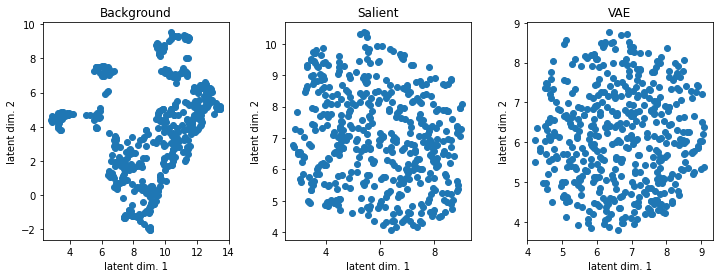

In [19]:
cscatter([bg_space,sl_space,vae_space],v=patients)

In [20]:
%%time
v = patients
rdm_bg = 1-make_RDM(bg_space[v,:],data_scale='ratio')
rdm_sl = 1-make_RDM(sl_space[v,:],data_scale='ratio')
rdm_vae = 1-make_RDM(encoder.predict(ABIDE_data)[2][v,:],data_scale='ratio')

CPU times: user 1.2 s, sys: 599 ms, total: 1.8 s
Wall time: 791 ms


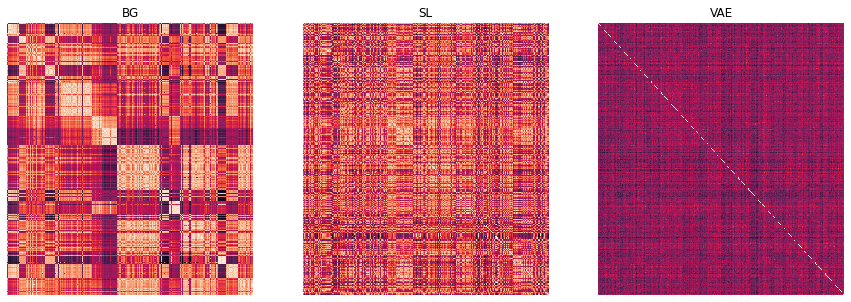

In [21]:
f, ax = plt.subplots(1,3,figsize=(15,5))
sns.heatmap(rdm_bg,cbar=[],ax=ax[0],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_sl,cbar=[],ax=ax[1],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_vae,cbar=[],ax=ax[2],xticklabels=[],yticklabels=[]);

[ax[i].set_title(['BG','SL','VAE'][i]) for i in range(3)];

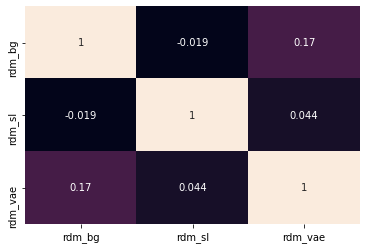

In [22]:
space_cmat = np.corrcoef(np.array([get_triu(x) for x in [rdm_bg,rdm_sl,rdm_vae]]));
lbls= ['rdm_bg','rdm_sl','rdm_vae'];
sns.heatmap(space_cmat,annot=True,cbar=[],xticklabels=lbls,yticklabels=lbls);

In [23]:
import sklearn.mixture

In [31]:
#svec = s_encoder.predict(ABIDE_data[:,:,:,:])[2]

In [32]:
bnp = sklearn.mixture.BayesianGaussianMixture(n_components=4,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=1000,
    n_init=10,
    init_params='kmeans',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=None,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=None,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10)

In [44]:
cid_sl = bnp.fit_predict(sl_space)
cid_bg = bnp.fit_predict(bg_space)
cid_vae = bnp.fit_predict(vae_space)
len(np.unique(cid_sl))
len(np.unique(cid_bg))

4

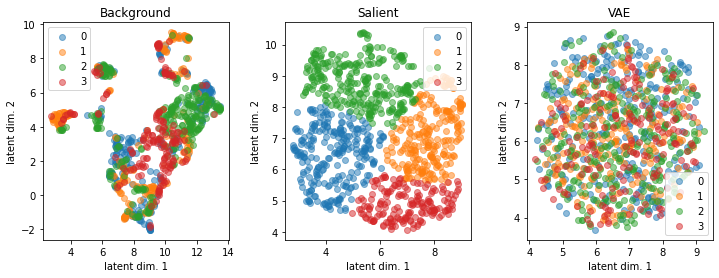

In [45]:
cscatter([bg_space,sl_space,vae_space],c=cid_sl)

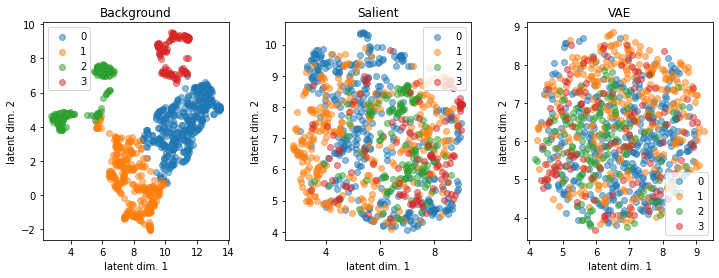

In [46]:
cscatter([bg_space,sl_space,vae_space],c=cid_bg)

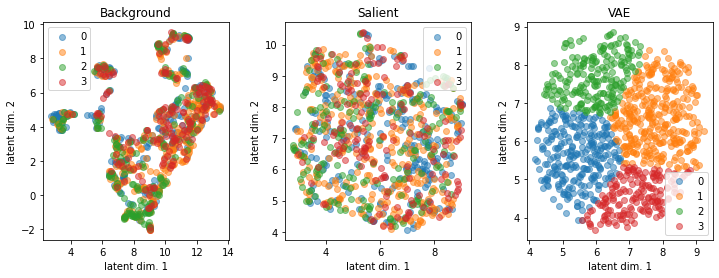

In [48]:
cscatter([bg_space,sl_space,vae_space],c=cid_vae)

In [90]:
arr = df.values
arr = np.array([pd.to_numeric(arr[:,i],errors='coerce') for i in range(arr.shape[1])])
isnan = np.isnan(arr)
arr = arr[arr.shape[1]-isnan.sum(axis=1)>100,:]

In [163]:
# 112 subjects
vineland_keys = ['VINELAND_Receptive_Vscore', 'VINELAND_Expressive_Vscore',
       'VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Play_Vscore',
       'VINELAND_Coping_Vscore', 'VINELAND_Socical_Standard',
       'VINELAND_Domestic_Standard', 'VINELAND_ABC_Standard',
       'VINELAND_Informant']

#55 subjects
wisc_keys = ['WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']

# 64 subjects
srs_keys = ['SRS_awareness', 'SRS_cognition', 'SRS_communication',
       'SRS_motivation', 'SRS_manierisms']

# [401, 377, 376, 317, 311, 310, 310, 283, 216, 212, 212, 211]
ados_keys = ['ADOS_Total',
 'ADOS_Social',
 'ADOS_Comm',
 'ADOS_StBeh',
 'ADI_R_VerbalTotal',
 'ADI_R_SocialTotal',
 'ADI_R_RRB',
 'ADI_R_Onset Total',
 'ADOSGotham_Rest-RepBeh',
 'ADOSGotham_Total',
 'ADOSGotham_Severity',
 'ADOSGotham_SocAffect']

#[887, 789, 788]
IQ = ['FIQ', 'VIQ', 'PIQ']

#[982, 982, 982, 982])
demog_keys = ['AgeAtScan', 'Sex', 'ScannerID', 'ScanSiteID','Handedness_Scores']

In [149]:
key = demog_keys

In [150]:
#[key[i] for i in np.argsort(np.isnan(df[key].values).sum(axis=0))]
arr.shape[1]-np.isnan(df[key].values).sum(axis=0)

array([982, 982, 982, 982])

In [ ]:
# plt.figure(figsize=(5,15))
# sns.heatmap(df[key].values,xticklabels=key)

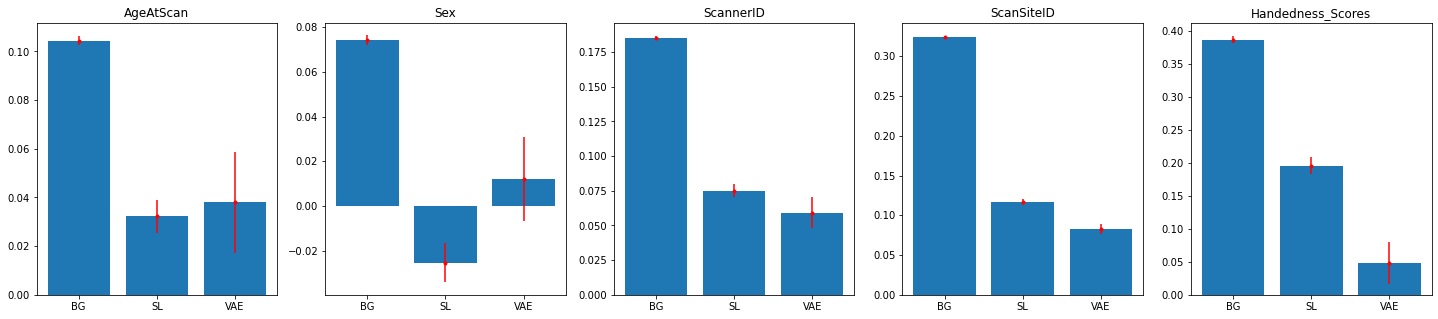

In [171]:
default_keys = demog_keys
scales_ = ['ratio','ordinal','ordinal','ordinal','ratio']
n = len(default_keys)
f,axs = plt.subplots(1,5,figsize=(25,5))

for i in range(n):
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,controls,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=axs[i],title=default_keys[i])

In [ ]:
default_keys = demog_keys
scales_ = ['ratio','ordinal','ordinal','ordinal','ratio']
n = len(default_keys)
f,axs = plt.subplots(1,5,figsize=(25,5))

for i in range(n):
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=axs[i],title=default_keys[i])

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None, solver='lbfgs', max_iter=1000, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [265]:
from scipy.stats import zscore

In [369]:
#['AgeAtScan','BMI']
keys = wisc_keys
df_use = df[patients]
arr = df_use[keys].dropna()

idx = list(arr.index);len(idx)
reducer = PCA(n_components=max(1,len(keys)))
components = reducer.fit_transform(arr.values)

In [370]:
#x = pd.get_dummies(df['Sex']).values[idx]

In [373]:
cid_sl[idx]

array([1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 3, 0, 2, 0, 0, 2, 0, 2])

/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1372, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 2

  warning

([<matplotlib.axis.XTick at 0x154c796dd910>,
 [Text(0, 0, 'BG'), Text(1, 0, 'SL'), Text(2, 0, 'VAE')])

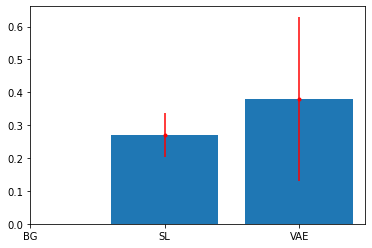

In [371]:
x = components
ncv = 5
acc_bg = cross_validate(clf, x, cid_bg[idx], cv=ncv)['test_score']
acc_sl = cross_validate(clf, x, cid_sl[idx], cv=ncv)['test_score']
acc_vae = cross_validate(clf, x, cid_vae[idx], cv=ncv)['test_score']

xs = [0,1,2];
m = [i.mean() for i in [acc_bg,acc_sl,acc_vae]];
se = [i.std() for i in [acc_bg,acc_sl,acc_vae]];

plt.bar(xs,m);
plt.errorbar(xs,m,se,fmt='r.');
plt.xticks(xs,labels=['BG','SL','VAE'])